In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11,8)})
from pathlib import Path

DATA = Path.cwd().parent / 'data' 
EFCAMDAT = DATA / 'efcamdat_shatz_distro.parquet'

In [2]:
df = pd.read_parquet(EFCAMDAT)

In [3]:
df.shape

(723282, 25)

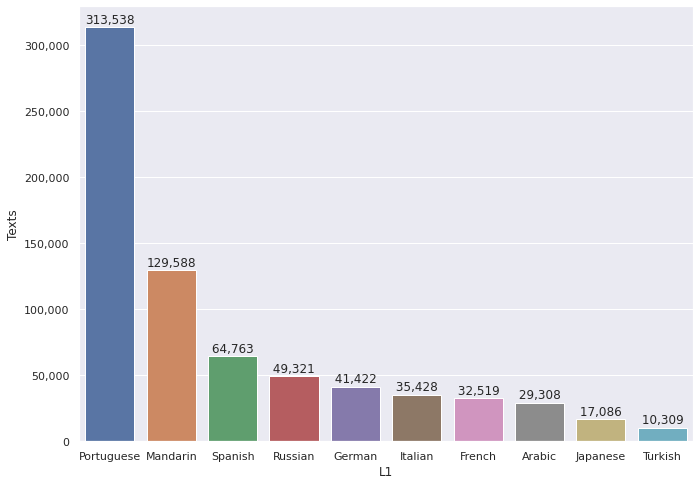

In [4]:
comma_formatter = lambda x, _: f'{x:,.0f}'
fig = sns.countplot(x=df.l1,
                    order=df.l1.value_counts().sort_values(ascending=False).index)
fig.axes.yaxis.set_major_formatter(comma_formatter)
for p in fig.patches:
    fig.annotate('{: >7,}'.format(p.get_height()), (p.get_x(), p.get_height()+3000))
fig.set(xlabel='L1', ylabel='Texts')
plt.savefig(Path.cwd().parent / 'images' / 'texts-by-language-bar.png')

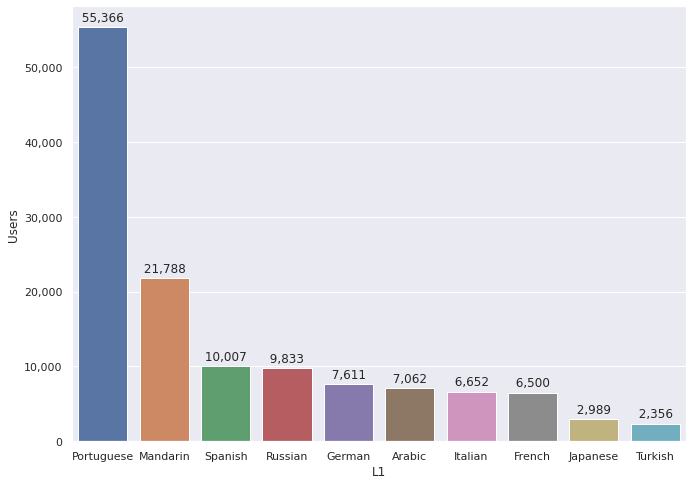

In [5]:
fig = sns.barplot(data=df.groupby(['l1']).learner_id.nunique().sort_values(ascending=False).to_frame().reset_index(), x='l1', y='learner_id')
fig.axes.yaxis.set_major_formatter(comma_formatter)
for p in fig.patches:
    fig.annotate('{: >7,}'.format(int(p.get_height())), (p.get_x(), p.get_height()+800))
fig.set(xlabel='L1', ylabel='Users')
plt.savefig(Path.cwd().parent / 'images' / 'users-by-language-bar.png')

<AxesSubplot:xlabel='level', ylabel='wordcount'>

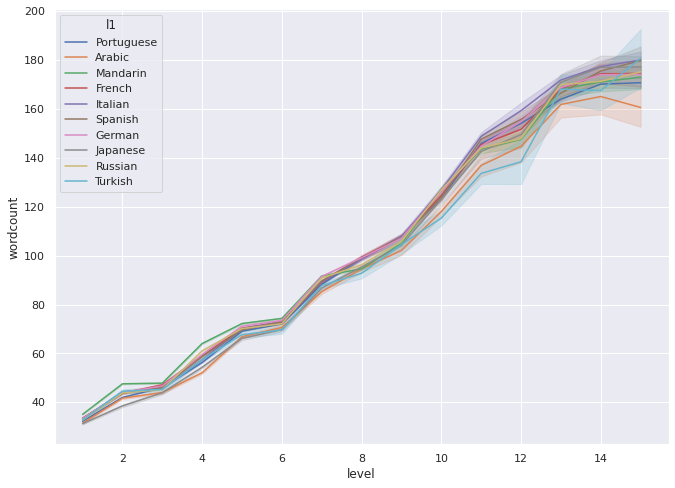

In [48]:
sns.lineplot(data=df.reset_index(), x='level', y='wordcount', hue='l1')

In [59]:
from spellchecker import SpellChecker

spell = SpellChecker()
text = print(df[df['level']==1].iloc[essay_num]['text'])
word_list = text.split()
# # find those words that may be misspelled
# misspelled = spell.unknown(word_list)
# misspelled


	  Hello Anna, I'm fine, thanks. My name's Nicole. I'm 61 years old. What's your phone number ? My phone number is ## ## ## ## ## Goodbye Nicole
	


AttributeError: 'NoneType' object has no attribute 'split'